In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import math
from IPython.display import clear_output
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.core.dtypes.cast import maybe_box_datetimelike
from copy import deepcopy
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.nn.modules.container import Sequential
from torch.utils.data import random_split, TensorDataset, Dataset, DataLoader

import torchvision
from torchvision import datasets


from drive.MyDrive.Model_trainer import CustomStructureDataset, First_CNN, ProgressPlotter

import random


def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [3]:
! pip install torchmetrics
clear_output()

In [5]:
#Загрузка train, val, test датасетов
train_dataset = CustomStructureDataset('drive/MyDrive/Dataset/Data_files_10_clear_added.csv', str_dir = 'drive/MyDrive/Dataset')
val_dataset = CustomStructureDataset('drive/MyDrive/Val_dataset/Data_files_short_clear_90.csv', str_dir = 'drive/MyDrive/Val_dataset')
test_dataset = CustomStructureDataset('drive/MyDrive/Dataset/Resol_test.csv', str_dir = 'drive/MyDrive/Dataset')

In [6]:
# расчет среднего и дисперсии для нормализации целевых значений
train_labels = torch.Tensor(list(train_dataset.str_labels[2].astype(float)))
mean = torch.mean(train_labels).item()
std = torch.std(train_labels).item()
print(mean, std)

7.4869866371154785 2.1831159591674805


In [7]:
# расчет весов, в случае обучения с weightedsampler
weights = []
for i in train_labels:
  delta = abs(i-mean).item()
  if delta<=1:
    delta=1
  weights.append(delta)

In [8]:

train_dataset.normalize = True # нормализация целевых значений
train_dataset.mean = mean
train_dataset.std = std
train_dataset.train = False # в случае, если train = True, с вероятностью 0.5 происходит замена -1 на 1 и наоборот
train_dataset.transform = True # в случае, если transform = True, с вероятностью 0.5 происходит зеркальное отражение по одной из осей

val_dataset.train = False
val_dataset.normalize = True
val_dataset.mean = mean
val_dataset.std = std
val_dataset.transform = None

test_dataset.train = False
test_dataset.normalize = True
test_dataset.mean = mean
test_dataset.std = std
test_dataset.transform = None


In [9]:
from torch.utils.data import WeightedRandomSampler
batch_size = 32
#weightedsampler = WeightedRandomSampler(weights, len(weights))
one_list = [1 for i in range(len(weights))]
weightedsampler = WeightedRandomSampler(one_list, len(weights))

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler = weightedsampler, num_workers=2)
#train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

val_loader = DataLoader(val_dataset, shuffle=False, batch_size=1, num_workers=2)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=1, num_workers=2)

In [10]:
from torchmetrics import PearsonCorrCoef, R2Score, MeanSquaredError

def train_func(model, criterion, optimizer, num_epochs, best_metrics):
  pp = ProgressPlotter(title="baseline", groups=["loss"])
  loss_hist = [] # for plotting
  acc_val_list = []
  val_loss_hist = [] # for plotting
  for epoch in range(num_epochs):
      model.train()
      hist_loss = 0
      for _, batch in tqdm(enumerate(train_loader, 0)): # get batch
          # parse batch
          structure, labels = batch
          structure, labels = structure.to(device=device, dtype=torch.float), labels.to(device=device, dtype=torch.float)
          # sets the gradients of all optimized tensors to zero.
          optimizer.zero_grad()
          # get outputs
          y_pred = model(structure)
          y_pred = torch.reshape(y_pred, (-1,))
          # calculate loss
          loss = criterion(y_pred, labels)
          # calculate gradients
          loss.backward()
          # performs a single optimization step (parameter update)
          optimizer.step()
          hist_loss += loss.item()
      loss_hist.append(hist_loss / len(train_loader))

      pred_list_val = []
      labels_list_val = []
      pred_list_norm = []
      labels_list_norm = []
      pearson = PearsonCorrCoef().to(device)
      model.eval()
      with torch.no_grad():
        for struct_val, labels_val in val_loader:
          struct_val, labels_val = struct_val.to(device=device, dtype=torch.float), labels_val.to(device=device, dtype=torch.float)
          pred_val = model(struct_val.to(device))
          labels_list_val.append(labels_val[0].item()*std+mean)
          pred_list_val.append(torch.reshape(pred_val, (-1,))[0].item()*std+mean)
          pred_list_norm.append(torch.reshape(pred_val, (-1,))[0].item())
          labels_list_norm.append(labels_val[0].item())
      val_loss_hist = criterion(torch.Tensor(pred_list_norm).to(device), torch.Tensor(labels_list_norm).to(device))
      corr_coef= pearson(torch.Tensor(pred_list_val).to(device), torch.Tensor(labels_list_val).to(device))
      if corr_coef > best_metrics:
        best_metrics = corr_coef
        best_model = deepcopy(model)

      y_pred_train = torch.tensor([])
      y_true_train = torch.tensor([])
      pearson = PearsonCorrCoef() # класс для отрисовывания обучения в течение эпох
      for i, data in tqdm(enumerate(train_loader)):
        struct_train, labels_train = data
        struct_train, labels_train = struct_train.to(device=device, dtype=torch.float), labels_train.to(device=device, dtype=torch.float)
        pred_train = model(struct_train.to(device)).cpu().detach()
        y_true_train = torch.cat((y_true_train, (labels_train*std+mean).cpu().detach()))
        y_pred_train = torch.cat((y_pred_train, pred_train*std+mean))
      corr_coef_train= pearson(torch.squeeze(y_pred_train), y_true_train)

      print(f"Epoch={epoch} loss={loss_hist[epoch]:.4f} val_loss: {round(val_loss_hist.item(),3)} val_corr: {round(corr_coef.item(),3)}")
      pp.add_scalar(group="loss", value=loss_hist[epoch], tag="train")
      pp.add_scalar(group="loss", value=val_loss_hist.item(), tag="val")
      pp.add_scalar(
      group= 'corr', value=corr_coef_train.item(), tag="train")
      pp.add_scalar(
      group= 'corr', value=corr_coef.item(), tag="val")
      pp.display()
  return best_model

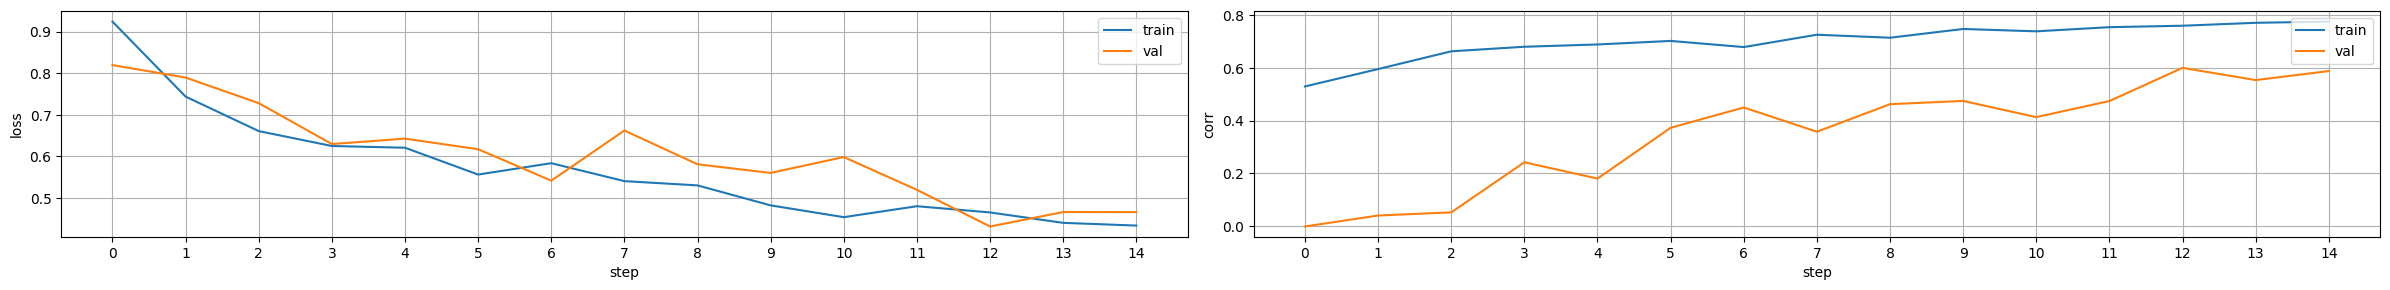

In [11]:
set_random_seed(42)
model = First_CNN()
model.to(device)

criterion = nn.MSELoss()
#criterion = nn.L1Loss()

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-3)
#optimizer = Lion(model.parameters(), lr=1e-5, weight_decay=1e-3)

num_epochs = 15
best_model = train_func(model, criterion, optimizer, num_epochs, 0)

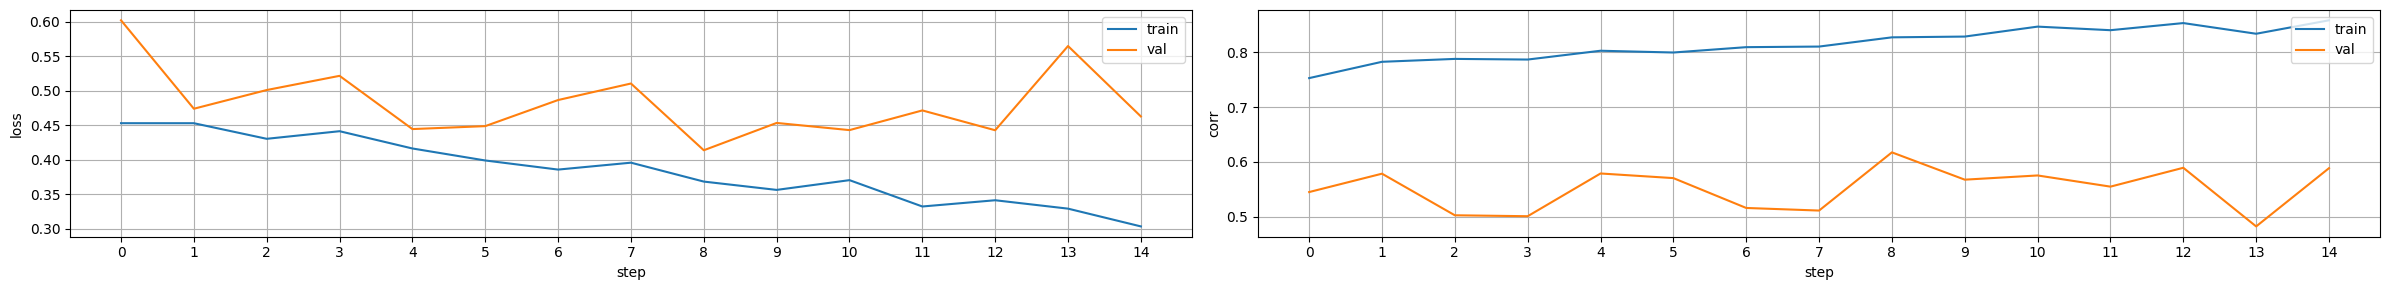

In [12]:
set_random_seed(42)
best_model.train()
optimizer = torch.optim.AdamW(best_model.parameters(), lr=0.0001, weight_decay=1e-3)
best_model2 = train_func(best_model, criterion, optimizer, 15, 0.5)

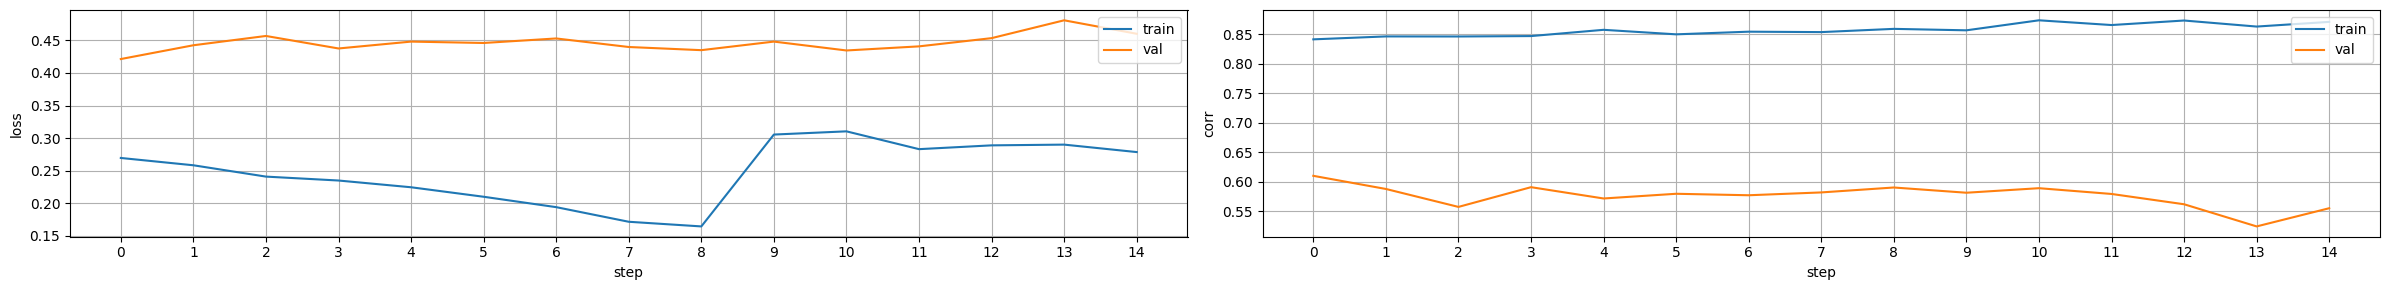

In [17]:
set_random_seed(42)
best_model2.train()
optimizer = torch.optim.AdamW(best_model2.parameters(), lr=0.00001, weight_decay=1e-3)
best_model3 = train_func(best_model2, criterion, optimizer, 15, 0.5)

In [13]:

def validate(model, test_loader, device = "cpu"):
  model.eval()
  pred_list = []
  labels_list = []
  for struct, labels in test_loader:
      struct, labels = struct.to(device=device, dtype=torch.float), labels.to(device=device, dtype=torch.float)
      pred = model(struct.to(device))
      labels_list.append(labels[0].item()*std+mean)
      pred_list.append(round(torch.reshape(pred, (-1,))[0].item()*std+mean, 2))

  pearson = PearsonCorrCoef().to(device)
  corr_coef= pearson(torch.Tensor(pred_list).to(device), torch.Tensor(labels_list).to(device))

  mse = MeanSquaredError().to(device)
  rmse = math.sqrt(mse(torch.Tensor(pred_list).to(device), torch.Tensor(labels_list).to(device)).item())

  print(f'PearsonCorr: {round(corr_coef.item(),2)}')
  print(f'RMSE: {round(rmse,3)}')
  return labels_list, pred_list

In [21]:
a, b = validate(best_model3, test_loader, device=device)

PearsonCorr: 0.6
RMSE: 1.478


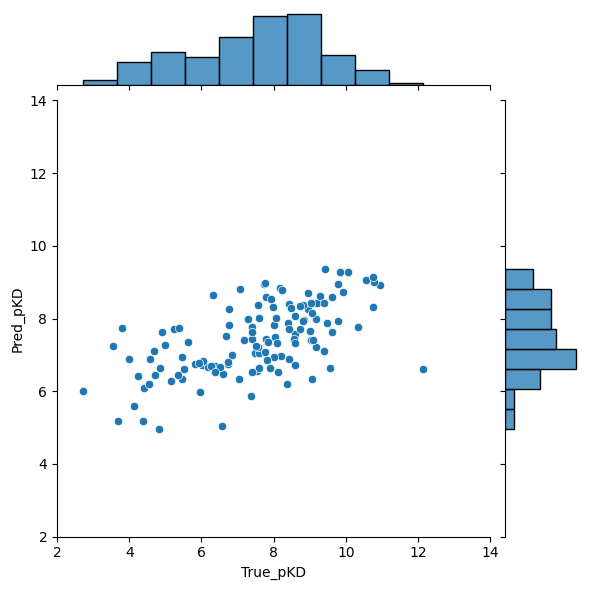

In [22]:
import seaborn as sns
corr_df = pd.DataFrame(columns=['Pred_pKD', 'True_pKD'])
corr_df['Pred_pKD'] = b
corr_df['True_pKD'] = a
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
sns.jointplot(data=corr_df, x='True_pKD', y='Pred_pKD', palette='Set2', ylim=(2, 14), xlim=(2, 14))

In [ ]:
torch.save(best_model3, 'drive/MyDrive/Model/model_best_weight_mol_dyn.pt')